In [1]:
import numpy as np
from PIL import ImageGrab
import cv2
from sklearn.cluster import DBSCAN
from sklearn.linear_model import LogisticRegression,LinearRegression,Lasso,Ridge
from sklearn.metrics import roc_auc_score
import win32gui
from digit_detector import digit_detector
from time import sleep
import keyboard
from direct_input import keyCodes,PressKey,ReleaseKey
import pickle
import matplotlib.pyplot as plt
import time

In [59]:
def getScreenShot(bbox):
    return np.array(ImageGrab.grab(bbox))

def getSpeedDigits(full_img):
    img = (full_img[987:1019,150:205].mean(axis =2) > 240).astype(np.int8)
    return [img[:,:16],img[:,17:33],img[:,35:51]]

def getSpeed(full_img):    
    return ("".join(digit_detector.predict(np.array([d.flatten() for d in getSpeedDigits(full_img)]))))


def roi(img, vertices):
    #blank mask:
    mask = np.zeros_like(img)
    # fill the mask
    cv2.fillPoly(mask, vertices, 255)
    # now only show the area that is the mask
    masked = cv2.bitwise_and(img, mask)
    return masked

def erase_region(img,vertices):
    #blank mask:
    mask = np.zeros_like(img)
    mask = mask + 255
    # fill the mask
    cv2.fillPoly(mask, vertices, 0)
    # now only show the area that is the mask
    masked = cv2.bitwise_and(img, mask)
    return masked
    

def draw_lines(img,lines,color = [255,255,255],size=3):
    if lines is not None:
        for coords in lines:
            if(coords is not None):
                coords = coords.astype(np.int32)
                cv2.line(img, (coords[0], coords[1]), (coords[2], coords[3]), color, size)

def process_img(image,debug=False):

    if debug:
        plt.figure(figsize=(20,20))
        plt.imshow(image)
        plt.show()
        sleep(2)
        
    image = cv2.bilateralFilter(image,5,75,75)
    
    if debug:
        plt.figure(figsize=(20,20))
        plt.imshow(image)
        plt.show()
        sleep(0.5)
 
    processed_img =  cv2.Canny(image, threshold1 = 100, threshold2=100)
    if debug:
        plt.figure(figsize=(20,20))
        plt.imshow(processed_img)
        plt.show()
        sleep(0.5)
    
    h,w = image.shape[:2]
    
    vertices = np.array([[0,780],[0,600],[480,350],[1440,350],[w,600],[w,780]], np.int32)
    
    car = np.array([[500,h],[850,450],[1050,450],[1500,h]],np.int32)
    
#     gui = np.array([[0,900],[300,900],[300,1080],[0,1080]],np.int32)
    
    processed_img = roi(processed_img, [vertices])
    processed_img = erase_region(processed_img, [car])
#     processed_img = erase_region(processed_img,[gui] )

    if debug:
        plt.figure(figsize=(20,20))
        plt.imshow(processed_img)
        plt.show()
        sleep(0.5)
    
    lines = cv2.HoughLinesP(processed_img,rho = 1,theta = 1*np.pi/180,threshold = 100,minLineLength = 200,maxLineGap = 100)
    if lines is not None:
        lines = lines[:,0,:]
        line_angles = np.arctan2(lines[:,2] - lines[:,0] , lines[:,1] - lines[:,3])*180/3.14
        lines = lines[(line_angles  > 100) | (line_angles  < 80) ]
     
    if debug:
        plt.figure(figsize=(20,20))
        draw_lines(processed_img,lines)
        plt.imshow(processed_img)
        plt.show()
        sleep(0.5)
    
    return lines

def getBorderLines(img,debug=False):
    lines = process_img(img,debug)
    if(len(lines)>0):
        clst = DBSCAN(eps=0.4)
        angles = np.arctan2(lines[:,2] - lines[:,0] , lines[:,1] - lines[:,3])
        preds = clst.fit_predict(angles[:,None])
        line1,line2 = None,None
        if (preds==0).any():
            line1 = lines[preds==0].mean(axis=0)
        if (preds==1).any():
            line2 = lines[preds==1].mean(axis=0)

        return line1,line2
    else:
        return None,None

def extend_lines(lines,scale):
    extended = []
    for line in lines:
        if line is not None:
            p1 = line[:2]
            p2 = line[2:]
            x1,y1 = (p1 + p2)*0.5 - (p2 - p1) * scale*0.5
            x2,y2 = (p1 + p2)*0.5 + (p2 - p1) * scale*0.5
            extended.append(np.array([x1,y1,x2,y2]))
    return extended

def limit_lines(lines, limit):
    results = []
    for line in lines:
        if line is not None:
            y_max_index = np.argmax(line[1::2])
            if y_max_index == 0:
                p1 = line[[0,1]]
                p2 = line[[2,3]]
            else:
                p2 = line[[0,1]]
                p1 = line[[2,3]]

            l = (p2 - p1)
            k = l[1]/l[0]
            x= p1[0] + -(p1[1] - limit)/k

            results.append(np.array([*p1,x,limit]))
    return results

def extend_lines(lines,scale):
    extended = []
    for line in lines:
        if line is not None:
            p1 = line[:2]
            p2 = line[2:]
            x1,y1 = (p1 + p2)*0.5 - (p2 - p1) * scale*0.5
            x2,y2 = (p1 + p2)*0.5 + (p2 - p1) * scale*0.5
            extended.append(np.array([x1,y1,x2,y2]))
    return extended

def limit_lines(lines, limit):
    results = []
    for line in lines:
        if line is not None:
            y_max_index = np.argmax(line[1::2])
            if y_max_index == 0:
                p1 = line[[0,1]]
                p2 = line[[2,3]]
            else:
                p2 = line[[0,1]]
                p1 = line[[2,3]]

            l = (p2 - p1)
            k = l[1]/l[0]
            x= p1[0] + -(p1[1] - limit)/k

            results.append(np.array([*p1,x,limit]))
    return results
        


In [3]:
enabeled = True
active = False
data = []
while(enabeled):
    if(keyboard.is_pressed('F6')):
        enabeled = False
    if(keyboard.is_pressed('F7')):
        active = not active
    if(active):
        img = getScreenShot((0,0,1920,1080))
        speed = getSpeed(img)
        lines = getBorderLines(img)
        keys = []
        for key in ['w','a','s','d']:
            keys.append(keyboard.is_pressed(key))        
        data.append([speed,lines,keys,time.time(),img])

In [68]:
i = 74

In [444]:
plt.imsave(f'data\\image_{i}.png',data[i][4])

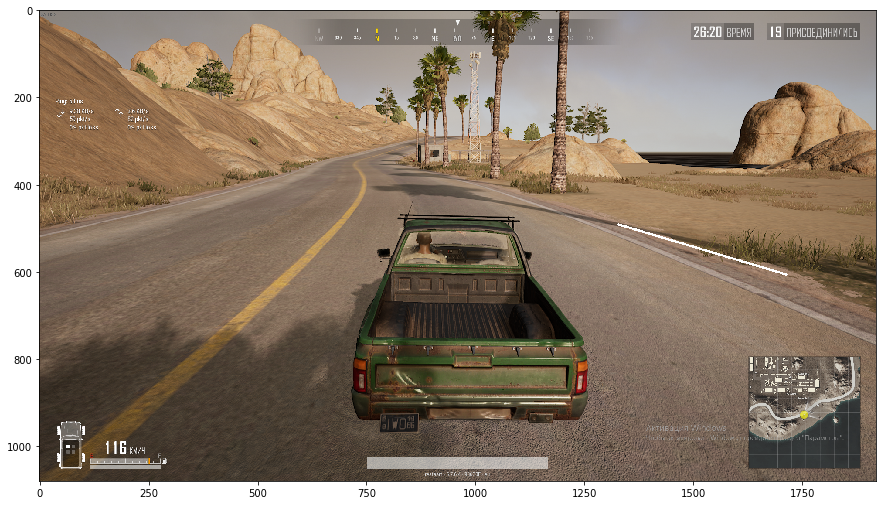

In [443]:
i+=2
plt.figure(figsize=(15,15))
im = data[i][4].copy()
draw_lines(img=im,lines=data[i][1])
plt.imshow(im)
plt.show()


In [9]:
%%time
img = getScreenShot((0,0,1920,1080))
speed = getSpeed(img)
lines = getBorderLines(img)
keys = []
for key in ['w','a','s','d']:
    keys.append(keyboard.is_pressed(key))
data.append([speed,lines,keys])

Wall time: 107 ms


In [18]:

with open('data.pkl', 'wb') as f:
    pickle.dump(data, f)

In [2]:
with open('data.pkl', 'rb') as f:
    data = pickle.load(f)

In [584]:
keys = np.array([d[2] for d in data])
speed = np.array([int(d[0]) if d[0]!='   ' else None for d in data])
lines = np.array([d[1] for d in data])

In [533]:
line0 = []
line1 = []
for line in np.array([d[1] for d in data]):
    if (line[0] is not None) and (line[1] is not None): 
        if(line[0][::2].mean()<1920*0.5):
            line0.append(line[0])
            line1.append(line[1])
        else:
            line1.append(line[0])
            line0.append(line[1])
    else:
        if line[0] is None:
            if line[1] is None:
                line0.append(np.array([None,None,None,None]))
                line1.append(np.array([None,None,None,None]))
            else:
                if(lines[1][::2].mean()<1920*0.5):
                    line0.append(line[1])
                    line1.append(np.array([None,None,None,None]))
                else:
                    line1.append(line[1])
                    line0.append(np.array([None,None,None,None]))
        else:
            if(lines[0][::2].mean()<1920*0.5):
                line1.append(np.array([None,None,None,None]))
                line0.append(line[0])
            else:
                line0.append(np.array([None,None,None,None]))
                line1.append(line[0])      
line0 = np.array(line0,dtype=np.float32)
line1 = np.array(line1,dtype=np.float32)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [62]:
draw_lines(img,[lines[0]],[255,0,0])

In [480]:
X = np.hstack([angles0[:,None],angles1[:,None],speed[:,None]])
X[np.isnan(X)] = 0

In [481]:
X = (X - X.mean(axis=0))/X.std(axis=0)

In [560]:
yw,ya,ys,yd = keys.astype(int).T
yw = filt(yw)
ya = filt(ya)
ys = filt(ys)
yd = filt(yd)

In [561]:
X_train, X_test = X[:1000],X[1000:]
yw_train, yw_test = yw[:1000],yw[1000:]
ya_train, ya_test = ya[:1000],ya[1000:]
ys_train, ys_test = ys[:1000],ys[1000:]
yd_train, yd_test = yd[:1000],yd[1000:]

-0.0035250124062380372


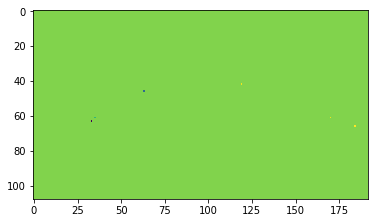

In [627]:
clfa = Lasso(alpha=3.6)
clfa.fit(X_train,ya_train)
print(clfa.score(X_test,ya_test))
plt.imshow(clfa.coef_.reshape((108,192)))
plt.show()

In [ ]:
[None ,]

-0.007110824557009066


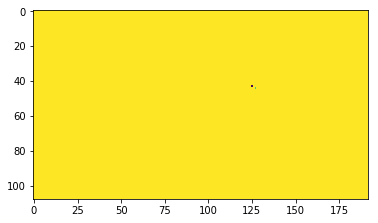

In [623]:
clfd = Lasso(alpha=3.9)
clfd.fit(X_train,yd_train)
print(clfd.score(X_test,yd_test))
plt.imshow(clfd.coef_.reshape((108,192)))
plt.show()

In [558]:
clfw = LogisticRegression()
clfw.fit(X_train,yw_train)
clfw.score(X_test,yw_test)

0.8298319327731093

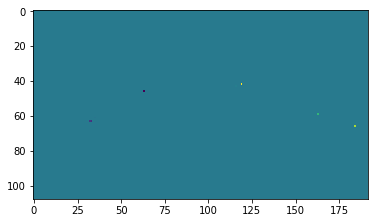

In [565]:
clfa.coef_

array([ 28607342.43293859,  16959806.73600427, -12413997.58314815, ...,
        -1265581.81492089,    794865.85774342,  -1727052.70254431])

In [520]:
roc_auc_score(clfa.predict(X),ya)

0.7634419152276296

In [488]:
def filt(d,k=0.3):
    d = np.array(d,dtype=np.float32)
    for i in range(1,d.size):
        d[i] = d[i-1]*(1-k)  +  d[i]*k
    return d
    

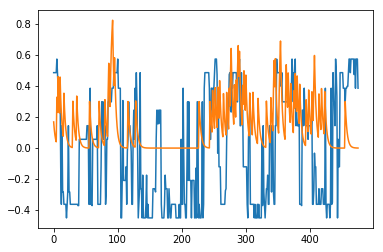

In [634]:
# plt.plot(X[:,2])
plt.plot((clfa.predict(X_test) - clfa.predict(X_test).mean())*60)
plt.plot(ya_test)
plt.show()

In [167]:
i = 0

In [585]:
X =  []
for line in lines:
    x = np.zeros((108,192),dtype=np.int8)
    if line[0] is not None:
        line[0] = line[0]/10
    if line[1] is not None:
        line[1] = line[1]/10
    line = extend_lines(line,10)
    line = limit_lines(line,40)
    draw_lines(x,line,size=5)
    x = x.flatten()
    X.append(x)
X = np.array(X)

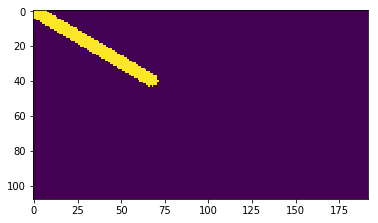

In [552]:
line = lines[0]
x = np.zeros((108,192),dtype=np.int8)
if line[0] is not None:
    line[0] = line[0]/10
if line[1] is not None:
    line[1] = line[1]/10
line = extend_lines(line,5)
line = limit_lines(line,40)
draw_lines(x,line,size=5)
plt.imshow(x)
plt.show()
x = x.flatten()

In [567]:
lines[0]

array([array([122.83,  42.02, 183.99,  77.86]),
       array([26.12, 77.88, 72.32, 40.28])], dtype=object)